# Locations of X-ray AGN displayed on a coadd image

This notebook demonstrates how to identify the coadd that covers a specific point. It then plots the locations of both DP1 and X-ray detections on that coadd.

The notebook uses the Data Butler to retrieve DP1 data, rather than the Table Access Platform (TAP). It includes a few neat features of the Data Butler that makes retrieving data a little more efficient.

## Import the required modules

In [2]:
from astropy.table import Table
from astropy.io import fits

import matplotlib.pyplot as plt

import lsst.afw.display as afwDisplay
import lsst.geom as geom

import lsst.daf.butler as dafButler

afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (8.0, 8.0)

## Set up the Data Butler and the Data Registry

In [3]:
# You can list the known repositories using:
# dafButler.ButlerRepoIndex.get_known_repos()
butler = dafButler.Butler('dp1', collections=['LSSTComCam/DP1'])
registry = butler.registry

In [6]:
# -------------------------------------------------------------------------#
# A list of collections within a repository is obtained using the
# following commented-out command.
# You don't need to have specified a collection when instantiating a Butler.
# -------------------------------------------------------------------------#

#registry.queryCollections('*')

## Read in the X-ray positions

In [7]:
hdul = fits.open('../DATA/ECDFS.fits')
data = hdul[1].data
table = Table(data)
xpos = table[['Seq', 'RAJ2000','DEJ2000']]

## What do I need to specify to identify a deep coadd?

In [8]:
registry.getDatasetType('deep_coadd').dimensions.required

{band, skymap, tract, patch}

In [9]:
# -------------------------------------------------------------------------#
# You can display the name of the skymap used in DP1 with using the 
# following commented-out command.
# -------------------------------------------------------------------------#

# list(registry.queryDimensionRecords('skymap'))

## Get the skymap, and use it to find the tract and patch that covers a position.

In [11]:
skymap = butler.get('skyMap', collections='skymaps', dataId={'skymap':'lsst_cells_v1'})

ra, dec = xpos['RAJ2000'][0], xpos['DEJ2000'][0]
coords = geom.SpherePoint(ra, dec, geom.degrees)

tract = skymap.findTract(coords)
tractId = tract.getId()
patch = tract.findPatch(coords)
patchId = patch.getSequentialIndex()

## Retrieve the g-band coadd for that tract and patch.

In [12]:
coadd = butler.get('deep_coadd', dataId={'tract':tractId, 'patch':patchId, 'skymap':'lsst_cells_v1', 'band':'g'})

## Display the coadd and overplot the positions of X-ray sources.

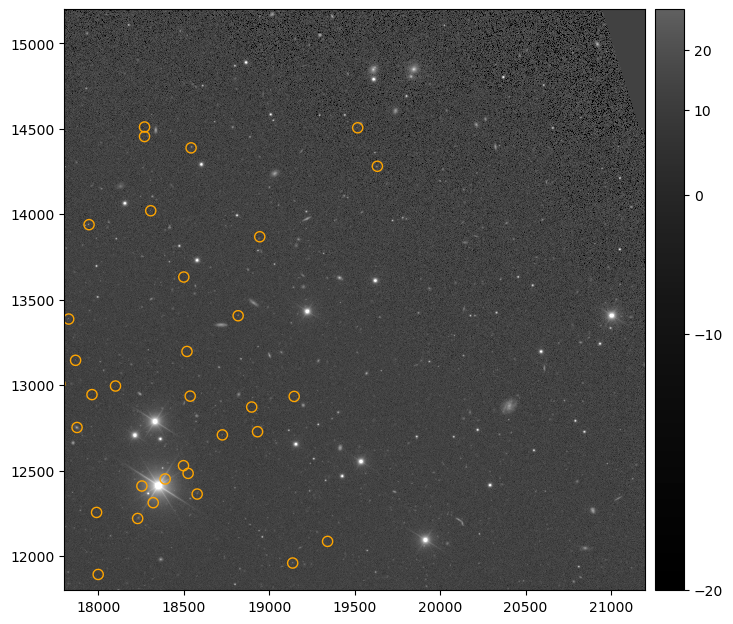

In [112]:
wcs = coadd.getWcs()
x, y = wcs.skyToPixelArray(xpos['RAJ2000'], xpos['DEJ2000'], degrees=True)

fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
with display.Buffering():
    for pos in zip(x,y):
        display.dot('o', pos[0], pos[1], size=30, ctype='orange')
plt.show()

## Alternatively, display using FireFly:

In [43]:
wcs = coadd.getWcs()
x, y = wcs.skyToPixelArray(xpos['RAJ2000'], xpos['DEJ2000'], degrees=True)

afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)
afw_display.mtv(coadd)

with afw_display.Buffering():
    for pos in zip(x,y):
        afw_display.dot('o', pos[0], pos[1], size=15, ctype='red')

## Retrieve the object table covering that tract

Unlike in TAP, the object catalogue in the Butler are stored on a per-tract basis. So we need to tell the butler the tract number when retrieving the object catalogue.

Rather than downloading the whole table, which contains 1279 columns, it's much more efficient to only select the columns that we want.

Once we have got the table, we can also filter on "patch" to only include those objects within our patch of interest, and on SNR to avoid plotting literally everything.

In [41]:
# -------------------------------------------------------------------------#
# Get the list of column names in the object table using the following
# commented-out line.
# -------------------------------------------------------------------------#

# objCols = butler.get('object.columns', tract=tractId)

In [49]:
columns = ['tract', 'patch', 'g_ra', 'g_dec', 'g_psfFlux', 'g_psfFluxErr']
obj = butler.get('object', tract=tractId, parameters={'columns':columns})
snr_selection = obj['g_psfFlux'] / obj['g_psfFluxErr'] >= 100

obj = obj[(obj['patch'] == patchId) & snr_selection]

In [51]:
x, y = wcs.skyToPixelArray(obj['g_ra'], obj['g_dec'], degrees=True)

afw_display.erase()
with afw_display.Buffering():
    for pos in zip(x,y):
        afw_display.dot('o', pos[0], pos[1], size=15, ctype='yellow')

## Retrieving only some contents of a data product

As we've seen, a coadd contains _more_ information than just the image (e.g., wcs information).

If you only want a specific piece of information for a coadd, or other type of data product, then you can often specify this in the butler.get command.

An example of this is the `object.columns` used above to only get the column names for the object table, so we didn't have to retrieve the whole table to
determine which columns we wanted to put into the `parameters`.

In [72]:
wcs = butler.get('deep_coadd.wcs', tract=tractId, patch=patchId, band='g')
x, y = wcs.skyToPixelArray(obj['g_ra'], obj['g_dec'], degrees=True)
print(x[0:5])

[18888.43306105 18732.1007995  20347.72931187 18031.7215692
 18707.07071548]


## How do I know what extensions I can add to a dataset type?

You can go to [the storage class definitions page on GitHub](https://github.com/lsst/daf_butler/blob/main/python/lsst/daf/butler/configs/storageClasses.yaml) or you can get it straight from the butler:

In [76]:
datasetType = registry.queryDatasetTypes('deep_coadd')
components = datasetType[0].storageClass.components

In [77]:
for component in components:
    print(component)

image
mask
variance
wcs
psf
photoCalib
visitInfo
apCorrMap
coaddInputs
transmissionCurve
metadata
filter
detector
validPolygon
summaryStats
id


## Speaking of which, how do I know what `parameters` I can provide?

That's also on [the storage class definitions page on GitHub](https://github.com/lsst/daf_butler/blob/main/python/lsst/daf/butler/configs/storageClasses.yaml) or you can do:

In [81]:
datasetType = registry.queryDatasetTypes('deep_coadd')
datasetType[0].storageClass.parameters

{'amp', 'bbox', 'detector', 'origin'}